### modules

In [1]:
import pandas as pd
import sys,os
sys.path.append("D:/Users/figohjs/Documents/Network")
from Script.generateHtml_v4 import generateHtml
from Script.helper_v2 import *
import json
import re
import numpy as np
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import itertools
%matplotlib inline

#adjust font size of graph
plt.rcParams.update({'font.size': 25})

### read data

In [79]:
# filename = "D:/Users/figohjs/Documents/Network/data/interim/2021-03-15_ScamSubgraphsDF.csv"
# filename = "D:/Users/figohjs/Documents/Network/data/interim/2021-03-17_ScamSubgraphsDF.csv"
filename = "D:/Users/figohjs/Documents/Network/data/interim/2021-03-25_ScamSubgraphsDF.csv"
df = pd.read_csv(filename)

#convert str to list - export issue 
def colBeList(colArray, colName):
    result = []
    for colList in [i.replace("{", '').replace('}', '')\
                     .replace("[", '').replace(']', '')\
                    .replace("\'", '').split(',') for i in colArray]:
        if colName in ['NeoIds', 'TransIds', 'TargetNeoIds']:
            result.append([int(i.strip()) if i!='set()' and i!= '' else '' for i in colList])
        else:
            result.append([i.strip() for i in colList])
    return result

colList = ['NeoIds', 'TransIds', 'TargetNeoIds']
for col in colList:
    if col in df.columns:
        df[col] = colBeList(df[col].values, col)

jsonFile = "D:/Users/figohjs/Documents/Network/data/interim/2021-02-19_ScamNetwork52Names.json"
with open(jsonFile, 'r') as f:
    tempGraphDict = json.load(f)

In [80]:
#only 20 networks have str related to scam or fraud 
dfScam = df[df['IsScamFraud']].copy()
dfScam.shape

(20, 28)

In [15]:
#count of account no by state
def countByState(dictArray):
    countDict = defaultdict(int)
    for i in dictArray:
        strToDict = json.loads(i.replace("'", "\""))
        for key, val in strToDict.items():
            countDict[key] += val
    return dict(countDict)

countByStateDict = countByState(dfScam['AccTotalByState'].values)

In [16]:
#count of account no by trx type
def countByTrxType(dictArray):
    countDict = defaultdict(int)
    for i in dictArray:
        strToDict = json.loads(i.replace("'", "\""))
        for key, val in strToDict.items():
            countDict[key] += val
    return dict(countDict)

countByTrxTypeDict = countByState(dfScam['AccTotalByTrxType'].values)

### UDF

In [61]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%d' % int(height),
                ha='center', va='bottom')

### Network Visualization

In [13]:
#one network example
dfSubset = pd.DataFrame(dfScam.iloc[1]).T

#convert data format to json
resultGraph = getNetworkJson(dfSubset, tempGraphDict, "TargetNeoIds")

#save json in a html format
htmlFile = "D:/Users/figohjs/Documents/Network/Html/ScamExample1.html"
generateHtml(resultGraph, htmlFile)

D:/Users/figohjs/Documents/Network/Html/ScamExample1.html is saved


### EDA

### Demographic

### Number of interconnected targets

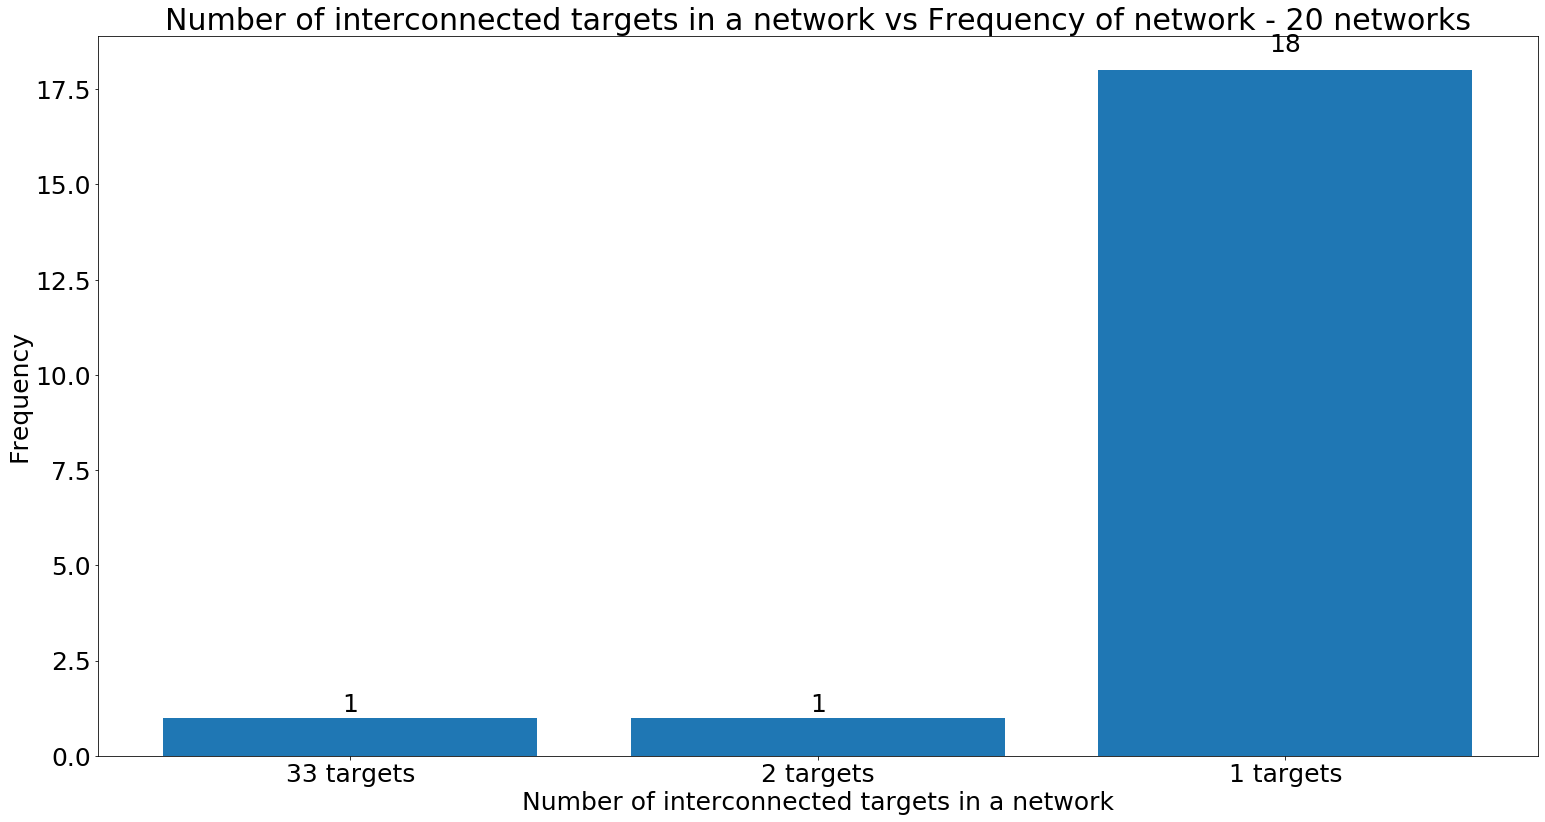

In [25]:
dfTemp = dfScam['NumberTargetNames'].value_counts()
sortedArray = sorted(dict(dfTemp).items(),reverse = True)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) + ' targets' for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Number of interconnected targets in a network vs Frequency of network - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of interconnected targets in a network')
autolabel(rects1)

# picName = 'Pic/NumTargetConVsFrequency.png'
# fig.savefig(picName, bbox_inches="tight")
plt.show()

### Number of STR

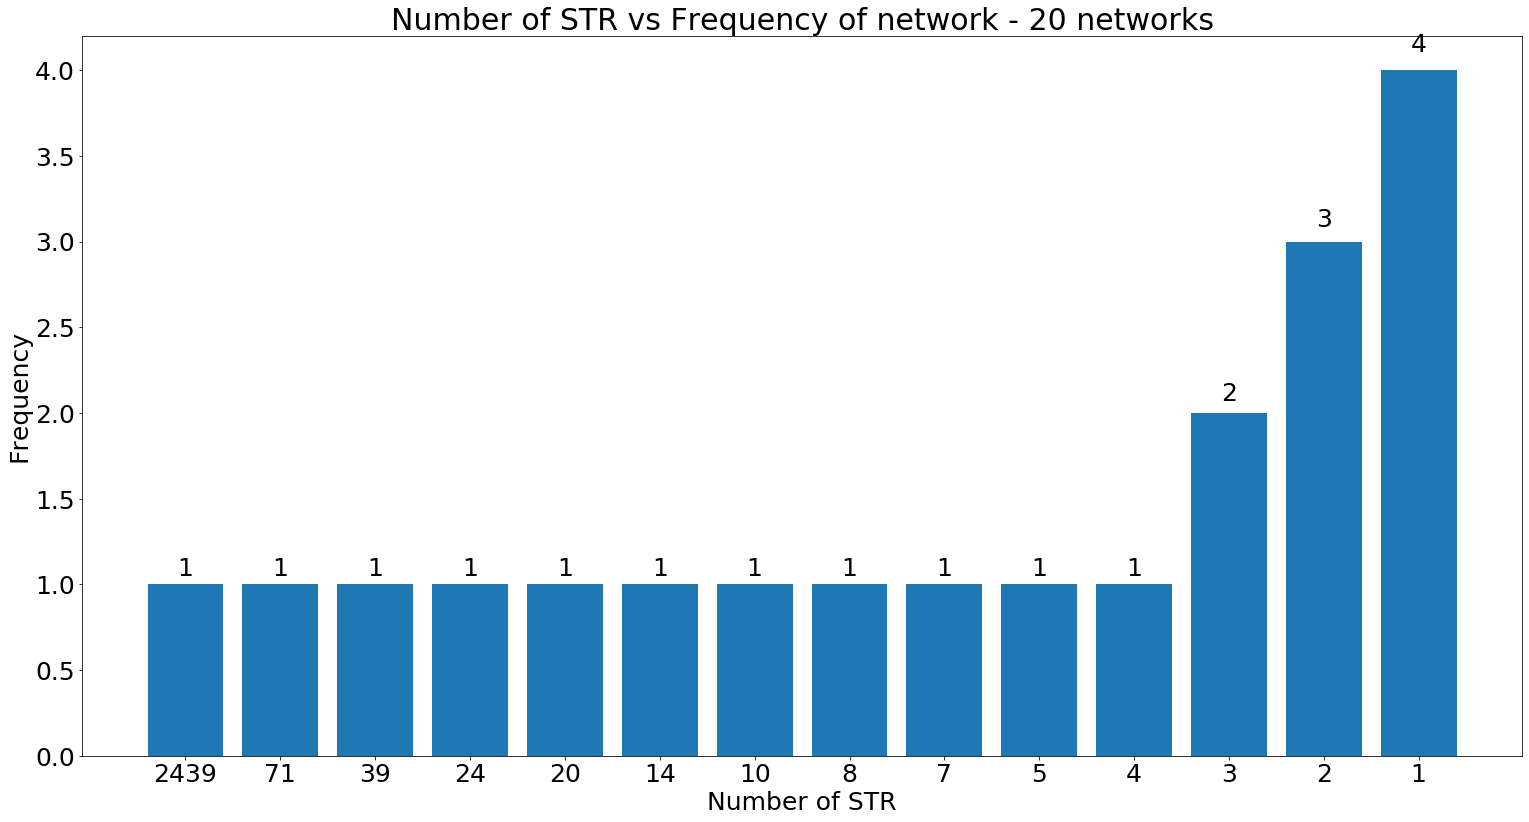

In [26]:
dfTemp = dfScam['NumStr'].value_counts()
sortedArray = sorted(dict(dfTemp).items(),reverse = True)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Number of STR vs Frequency of network - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of STR')
autolabel(rects1)

# picName = 'Pic/NumTargetConVsFrequency.png'
# fig.savefig(picName, bbox_inches="tight")
plt.show()

### Targets Sharing Contact Or Address

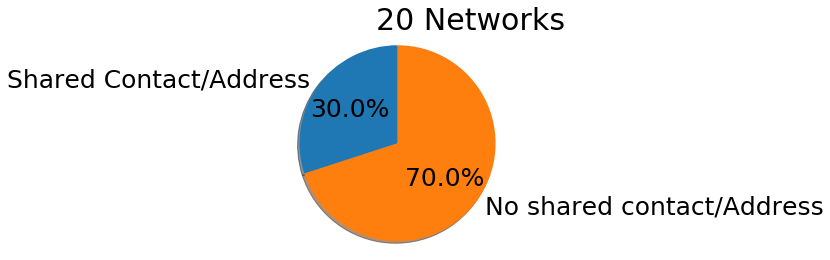

In [27]:
numShared = dfScam.query('TargetSharingContactOrAddress == 1').shape[0]
numNoShared = dfScam.shape[0] - numShared

#plot pie chart
labels = "Shared Contact/Address", "No shared contact/Address"
sizes = [numShared, numNoShared]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%',
        shadow = True, startangle = 90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('%s Networks'%dfScam.shape[0], loc = 'right')
# picName = 'Pic/SharedContactPie.png'
# fig1.savefig(picName, bbox_inches="tight")
plt.show()

### Occupation List

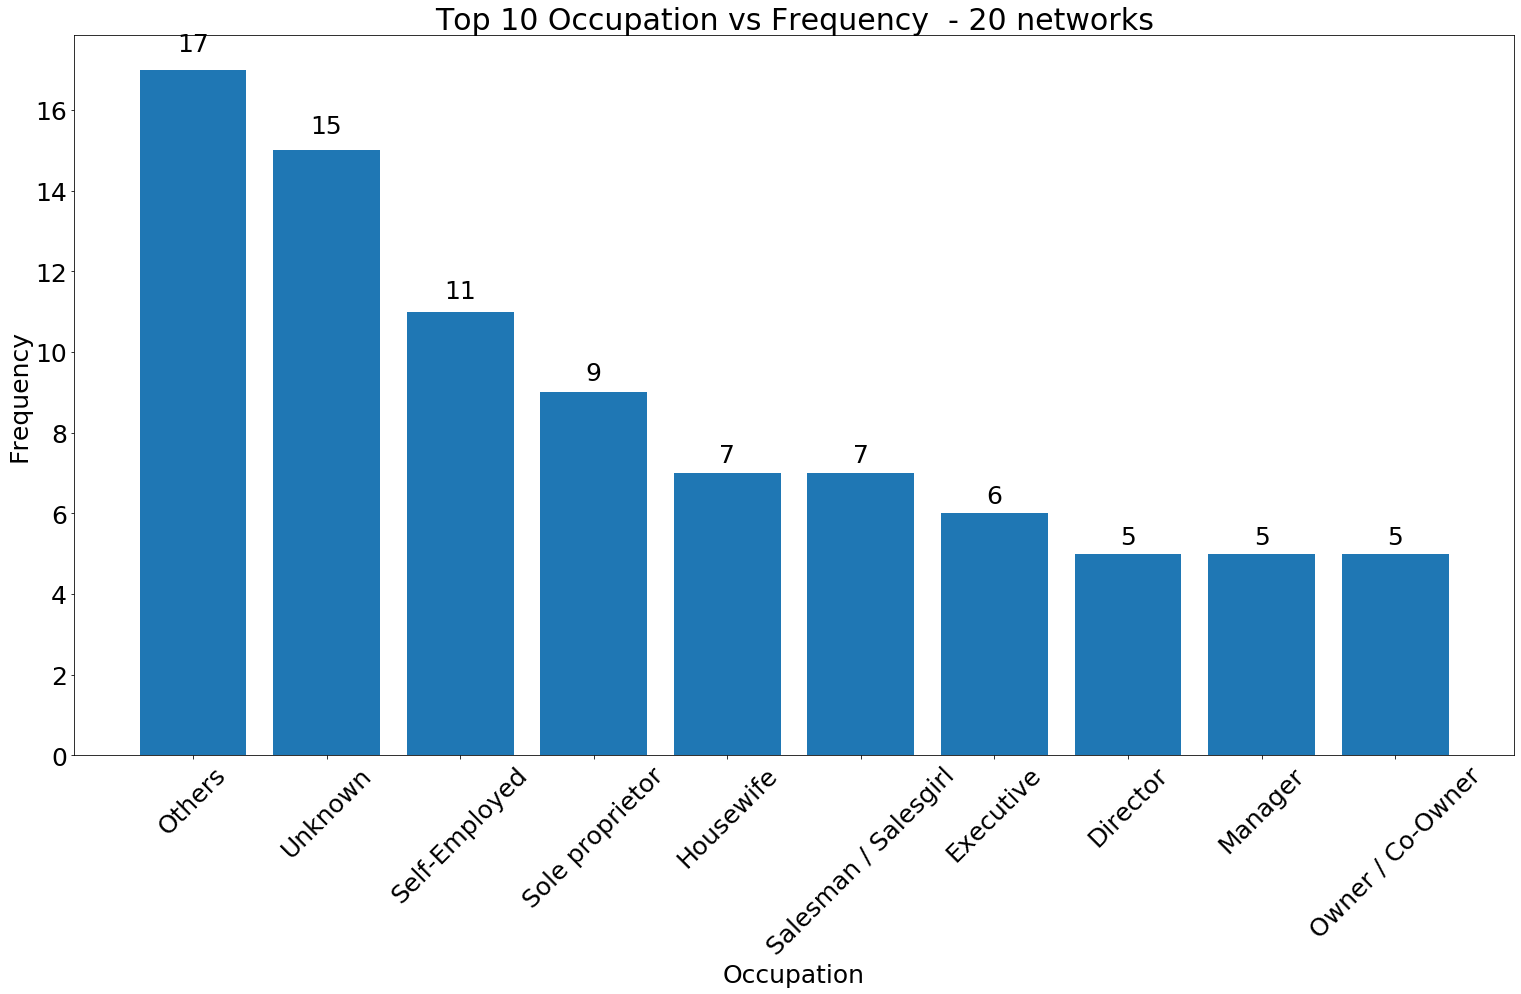

In [54]:
tempList = [i.split(',') for i in dfScam['TargetOccupationList'] if not isinstance(i, float)]
mergeList = list(itertools.chain(*tempList))

dfTemp = pd.Series(mergeList).value_counts()
sortedArray = sorted(dict(dfTemp).items(),key = lambda x:x[1], reverse = True)[:10]

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Top 10 Occupation vs Frequency  - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Occupation')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
autolabel(rects1)

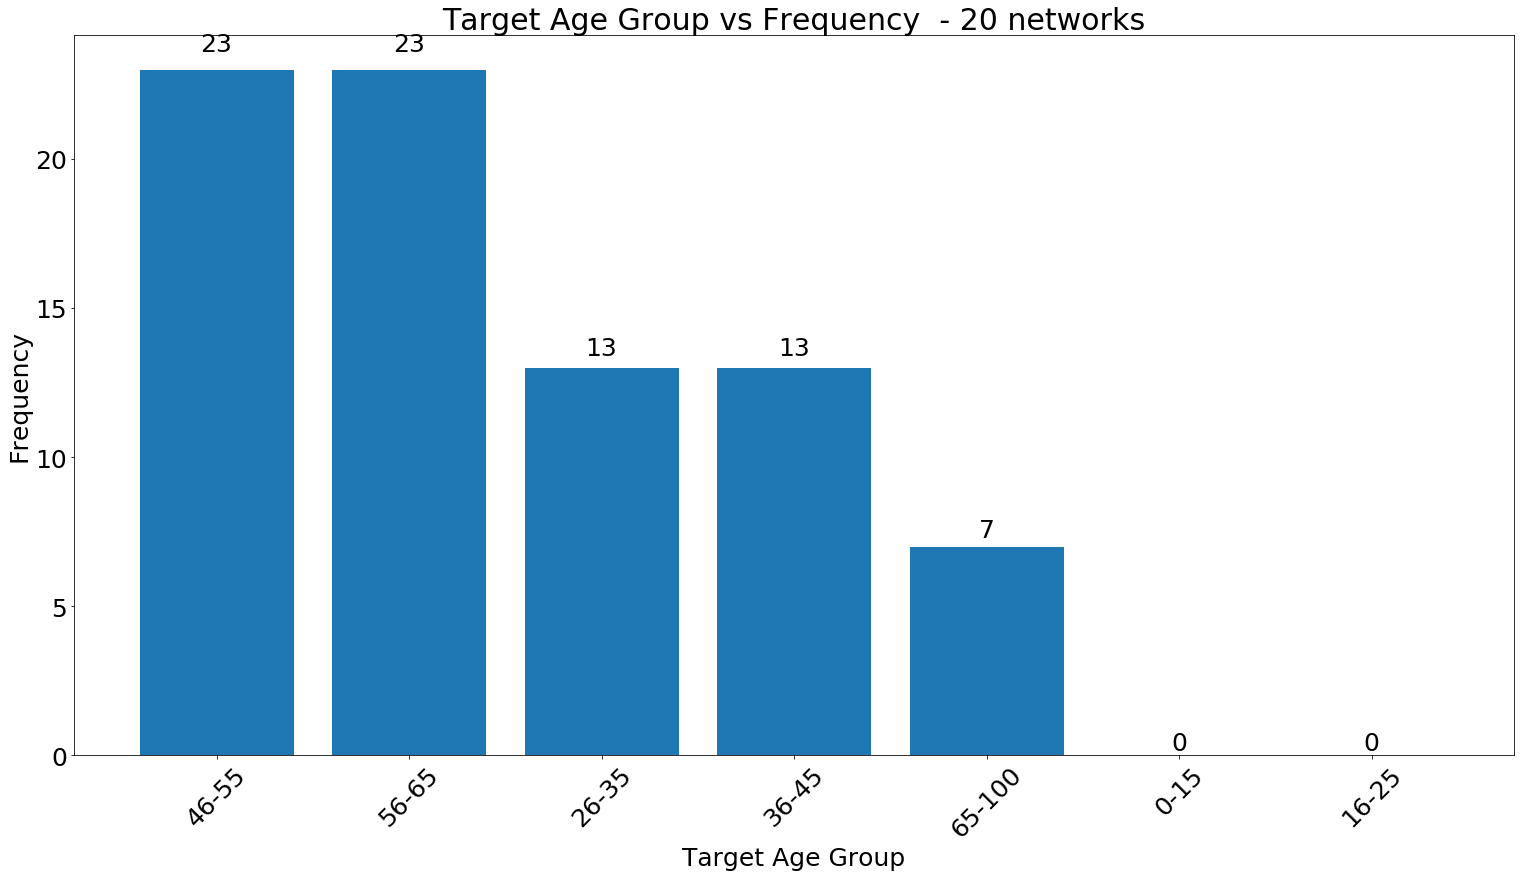

In [81]:
tempList = [i.split(',') for i in dfScam['TargetAgeList'] if not isinstance(i, float)]

ageGroup = ["0-15", "16-25", "26-35", "36-45", "46-55",
           "56-65", "65-100"]
ageGroupDict = {i:0 for i in ageGroup}
for i in [int(j) for i in tempList for j in i if j!='']:
    if i<=15:
        ageGroupDict["0-15"]+=1
    elif i<=25:
        ageGroupDict["16-25"]+=1
    elif i<=35:
        ageGroupDict["26-35"]+=1
    elif i<=45:
        ageGroupDict["36-45"]+=1
    elif i<=55:
        ageGroupDict["46-55"]+=1
    elif i<=65:
        ageGroupDict["56-65"]+=1
    else:
        ageGroupDict["65-100"]+=1

sortedArray = sorted(dict(ageGroupDict).items(),key = lambda x:x[1], reverse = True)
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Target Age Group vs Frequency  - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Target Age Group')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
autolabel(rects1)

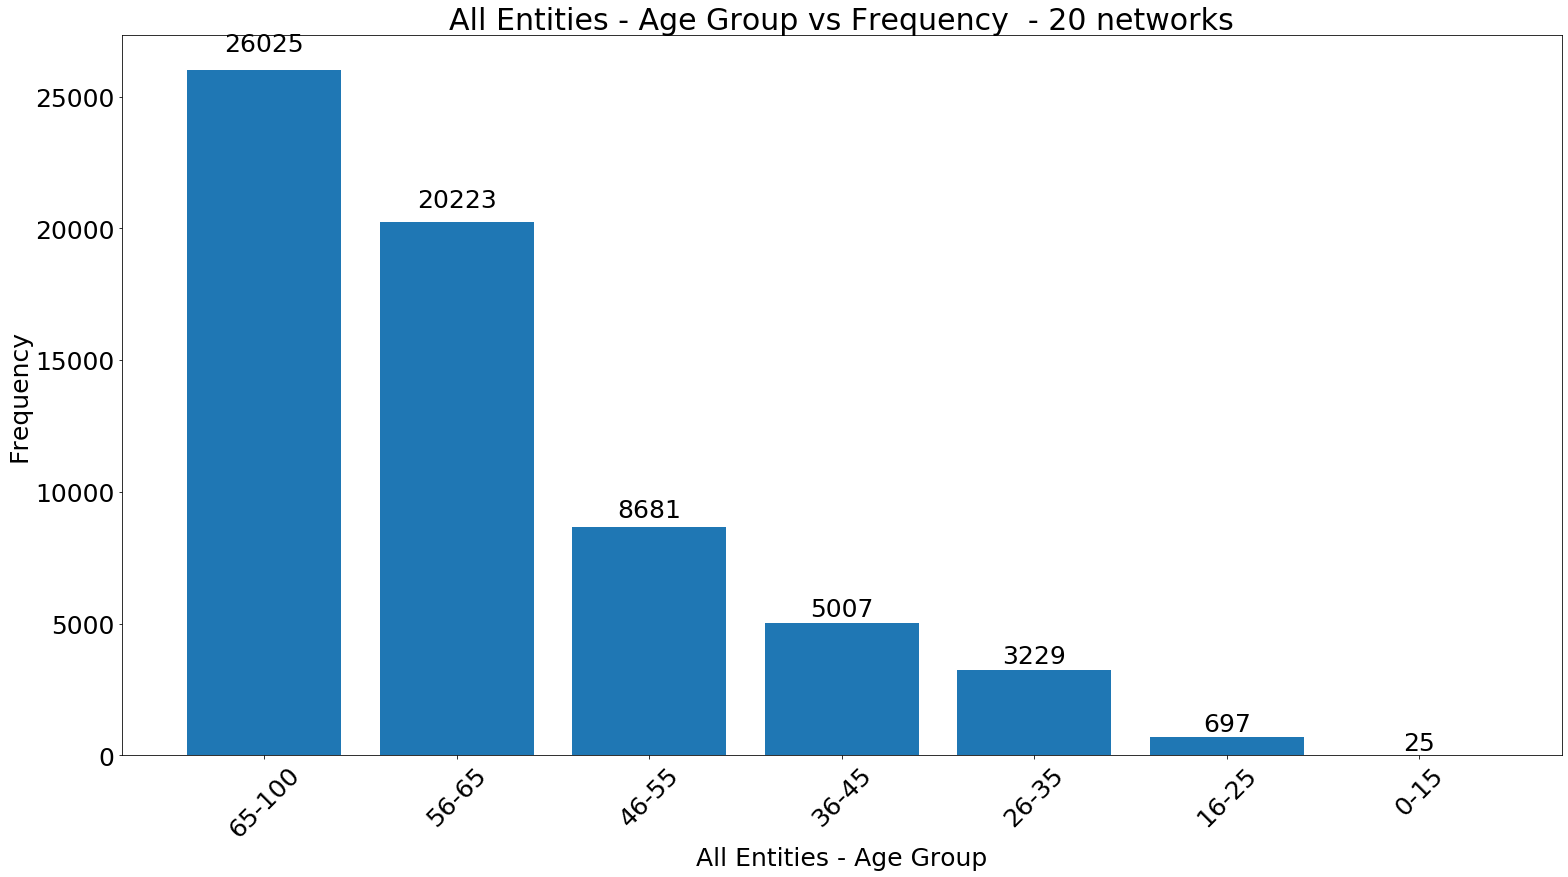

In [82]:
tempList = [i.split(',') for i in dfScam['AllAgeList'] if not isinstance(i, float)]

ageGroup = ["0-15", "16-25", "26-35", "36-45", "46-55",
           "56-65", "65-100"]
ageGroupDict = {i:0 for i in ageGroup}
for i in [int(j) for i in tempList for j in i if j!='']:
    if i<=15:
        ageGroupDict["0-15"]+=1
    elif i<=25:
        ageGroupDict["16-25"]+=1
    elif i<=35:
        ageGroupDict["26-35"]+=1
    elif i<=45:
        ageGroupDict["36-45"]+=1
    elif i<=55:
        ageGroupDict["46-55"]+=1
    elif i<=65:
        ageGroupDict["56-65"]+=1
    else:
        ageGroupDict["65-100"]+=1

sortedArray = sorted(dict(ageGroupDict).items(),key = lambda x:x[1], reverse = True)
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("All Entities - Age Group vs Frequency  - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('All Entities - Age Group')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
autolabel(rects1)

### RI

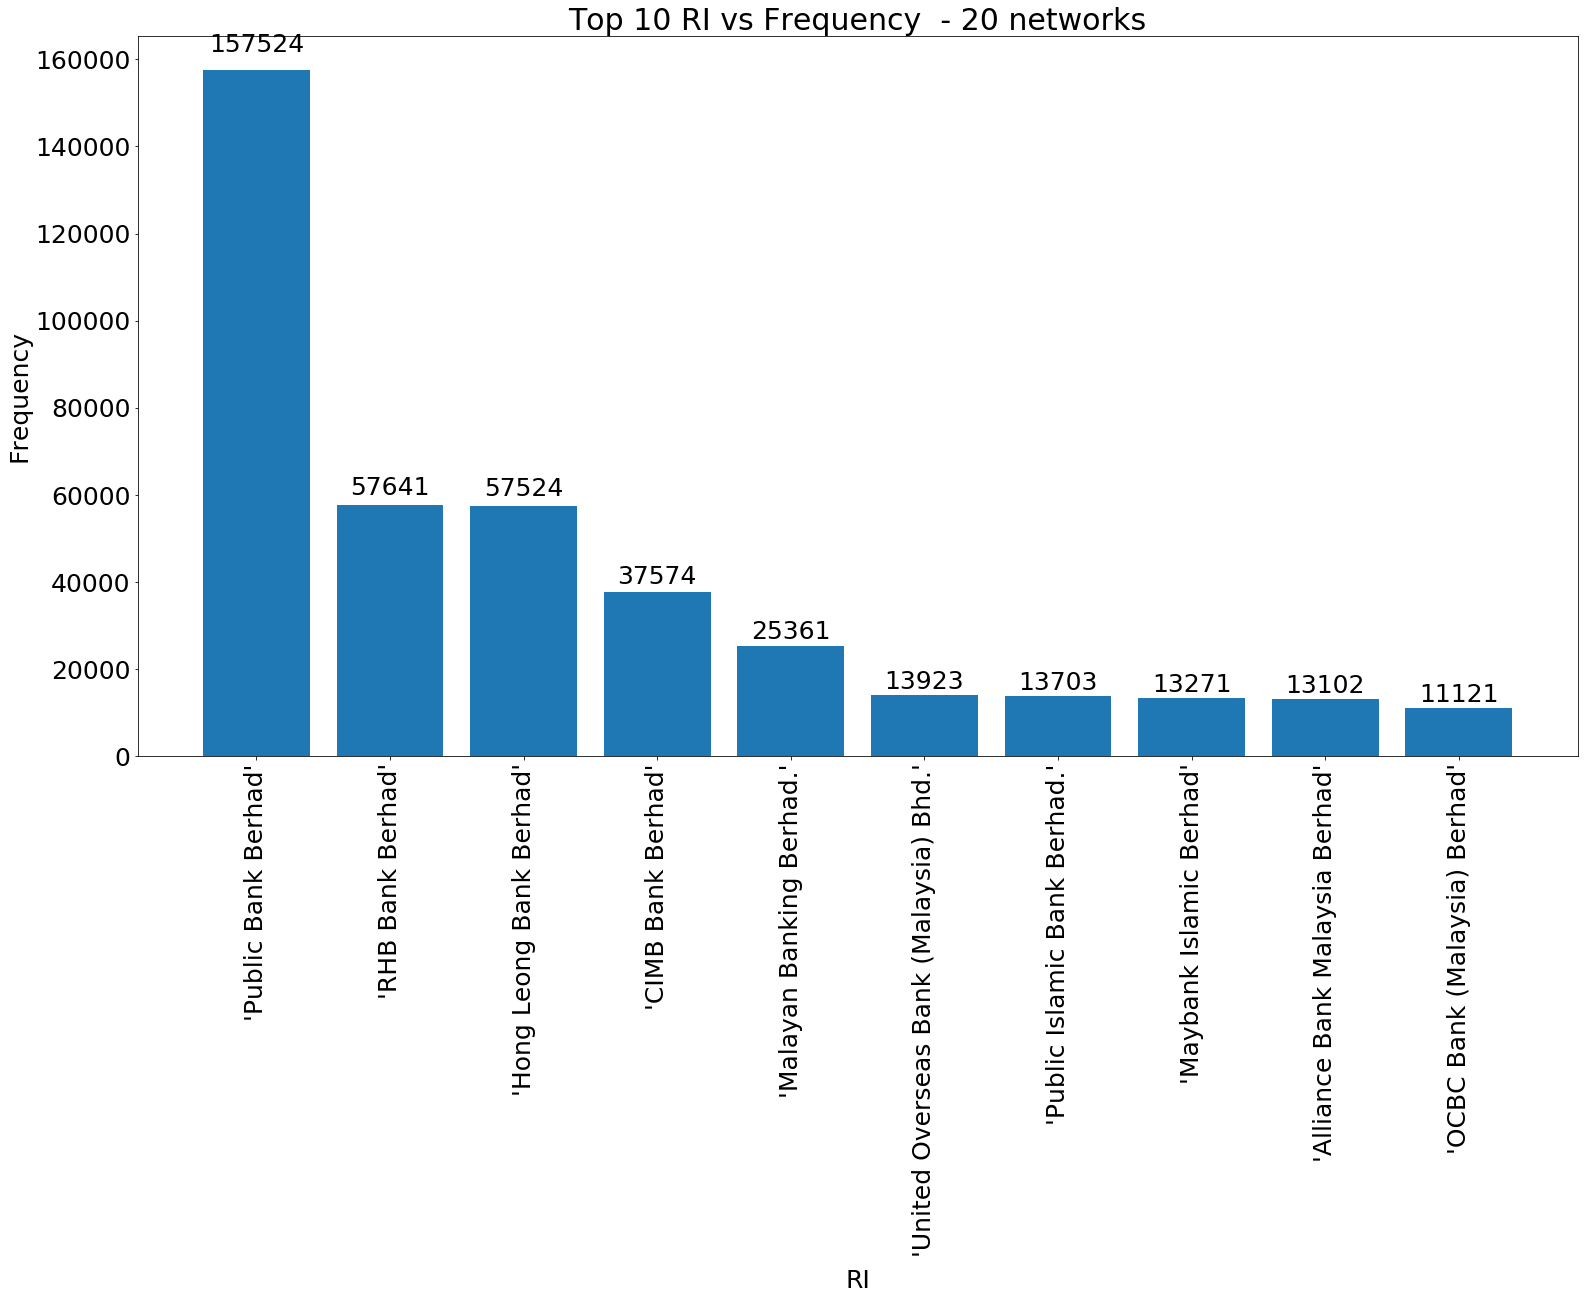

In [15]:
tempList = [i.split(',') for i in dfScam['RIList'] if not isinstance(i, float)]
mergeList = list(itertools.chain(*tempList))

dfTemp = pd.Series(mergeList).value_counts()
sortedArray = sorted(dict(dfTemp).items(),key = lambda x:x[1], reverse = True)[:10]

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Top 10 RI vs Frequency  - %s networks"%dfScam.shape[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('RI')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
autolabel(rects1)

### Transaction Type

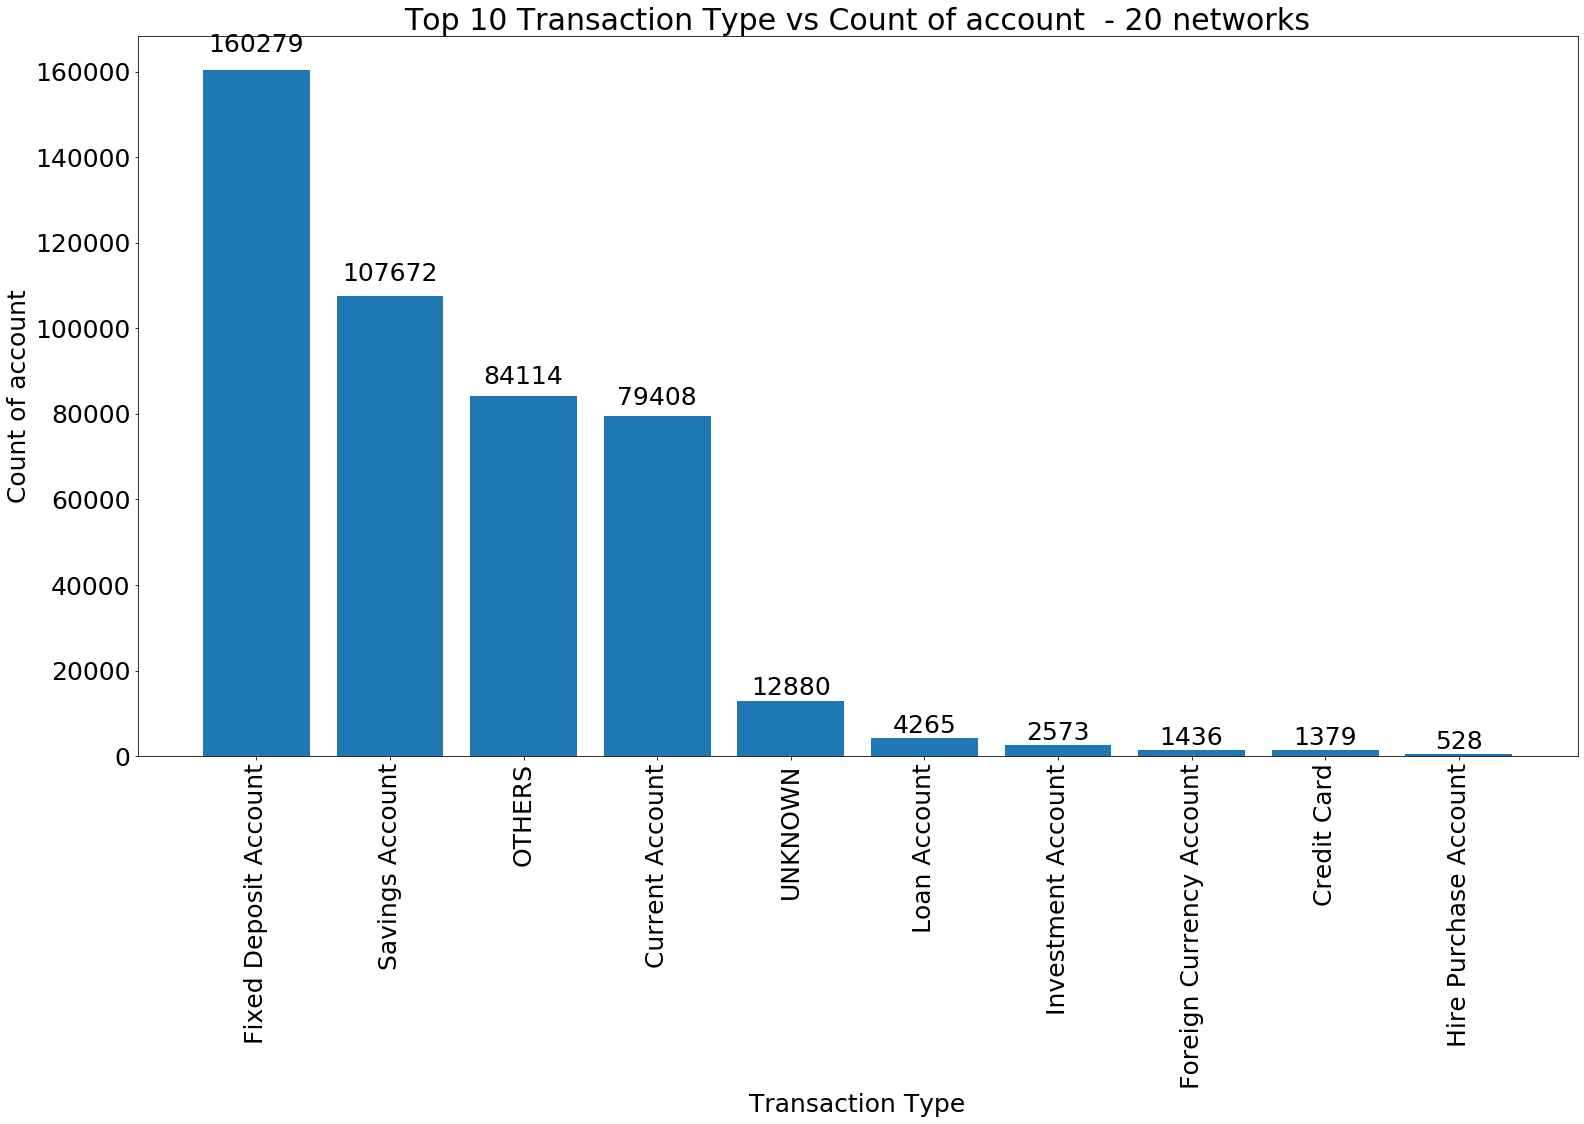

In [40]:
sortedArray = sorted(dict(countByTrxTypeDict).items(),key = lambda x:x[1], reverse = True)[:10]

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
numTarget = [str(i) for i in [i[0] for i in sortedArray]]
frequency = [i[1] for i in sortedArray]
rects1 = ax.bar(numTarget,frequency)
ax.set_title("Top 10 Transaction Type vs Count of account  - %s networks"%dfScam.shape[0])
ax.set_ylabel('Count of account')
ax.set_xlabel('Transaction Type')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
autolabel(rects1)

### Total number of account by state

In [17]:
jsonFile = "D:/Users/figohjs/Documents/Network/data/raw/states.geojson"
with open(jsonFile) as myJson:
    statesInfo = json.load(myJson)
jsonStateList = [i['properties']['Name'] for i in statesInfo['features']]

stateDict = {"PAHANG": "Pahang", "NEGERI SEMBILAN":'Negeri Sembilan',
            "SELANGOR":"Selangor", "W.P KUALA LUMPUR":'Federal Territory of Kuala Lumpur',
            'PULAU PINANG':'Penang', 'JOHOR':'Johor', 'PERLIS':'Perlis',
            'PERAK':'Perak', 'SABAH':'Sabah', 'SARAWAK':'Sarawak', 'KEDAH':'Kedah',
            "MELAKA":'Melaka', 'KELANTAN':'Kelantan', 'TERENGGANU':'Terengganu',
            'W.P PUTRAJAYA':'Federal Territory of Putrajaya', 'W.P LABUAN':'Federal Territory of Labuan'}

countByStateDictList = [[stateDict[i],j] for i,j in countByStateDict.items() if i in stateDict]

dfState = pd.DataFrame(countByStateDictList, columns = ['State', 'AccountCount'])

In [18]:
import plotly.graph_objs as go

fig = go.Figure(
    go.Choroplethmapbox(
        geojson=statesInfo,
        featureidkey="properties.Name",
        locations=dfState.State,
        z=dfState.AccountCount,
        zauto=True,
        colorscale='Reds',
        marker_opacity=0.8,
        marker_line_width=0.8,
        showscale=True,
    )
)
fig.update_layout(
    mapbox_style="carto-darkmatter",
    mapbox_zoom=3,
    mapbox_center={"lat": 3, "lon": 120},
    annotations = [dict(
                        x = 0.55,
                        y = 0.1,
                        font_size = 20,
                        font_color = "Red",
                        xref = 'paper',
                        yref = 'paper',
                        text = 'Total number of account',
                        showarrow = False
                    )]
)
htmlFile = "AccountByState.html"
fig.write_html(htmlFile)
fig.show()

In [3]:
jsonFile = "D:/Users/figohjs/Documents/Network/data/raw/states.geojson"
with open(jsonFile) as myJson:
    statesInfo = json.load(myJson)
jsonStateList = [i['properties']['Name'] for i in statesInfo['features']]

stateDict = {"PAHANG": "Pahang", "NEGERI SEMBILAN":'Negeri Sembilan',
            "SELANGOR":"Selangor", "W.P KUALA LUMPUR":'Federal Territory of Kuala Lumpur',
            'PULAU PINANG':'Penang', 'JOHOR':'Johor', 'PERLIS':'Perlis',
            'PERAK':'Perak', 'SABAH':'Sabah', 'SARAWAK':'Sarawak', 'KEDAH':'Kedah',
            "MELAKA":'Melaka', 'KELANTAN':'Kelantan', 'TERENGGANU':'Terengganu',
            'W.P PUTRAJAYA':'Federal Territory of Putrajaya', 'W.P LABUAN':'Federal Territory of Labuan'}


#normalized from yan ling
excelFile = "D:/Users/figohjs/Documents/Network/data/raw/account_bystate_normalized.xlsx"
df = pd.read_excel(excelFile)

In [14]:
dfDict = df.set_index(df.columns[0])['ratio'].to_dict()
countByStateNormal = [[stateDict[i],j] for i,j in dfDict.items() if i in stateDict]

dfState = pd.DataFrame(countByStateNormal, columns = ['State', 'NormalizedCount'])
dfState

,State,NormalizedCount
0,Federal Territory of Labuan,0.066472
1,Perak,0.063456
2,Melaka,0.060809
3,Federal Territory of Kuala Lumpur,0.057029
4,Penang,0.056683
5,Negeri Sembilan,0.055456
6,Sarawak,0.053644
7,Selangor,0.051165
8,Johor,0.050718
9,Pahang,0.049550


In [16]:
import plotly.graph_objs as go

fig = go.Figure(
    go.Choroplethmapbox(
        geojson=statesInfo,
        featureidkey="properties.Name",
        locations=dfState.State,
        z=dfState.NormalizedCount,
        zauto=True,
        colorscale='Reds',
        marker_opacity=0.8,
        marker_line_width=0.8,
        showscale=True,
    )
)
fig.update_layout(
    mapbox_style="carto-darkmatter",
    mapbox_zoom=3,
    mapbox_center={"lat": 3, "lon": 120},
    annotations = [dict(
                        x = 0.55,
                        y = 0.1,
                        font_size = 20,
                        font_color = "Red",
                        xref = 'paper',
                        yref = 'paper',
                        text = 'Normalized count by states',
                        showarrow = False
                    )]
)
htmlFile = "NormalizedCountByState.html"
fig.write_html(htmlFile)
fig.show()

### Network metrics

### Max Degree Centrality vs Density

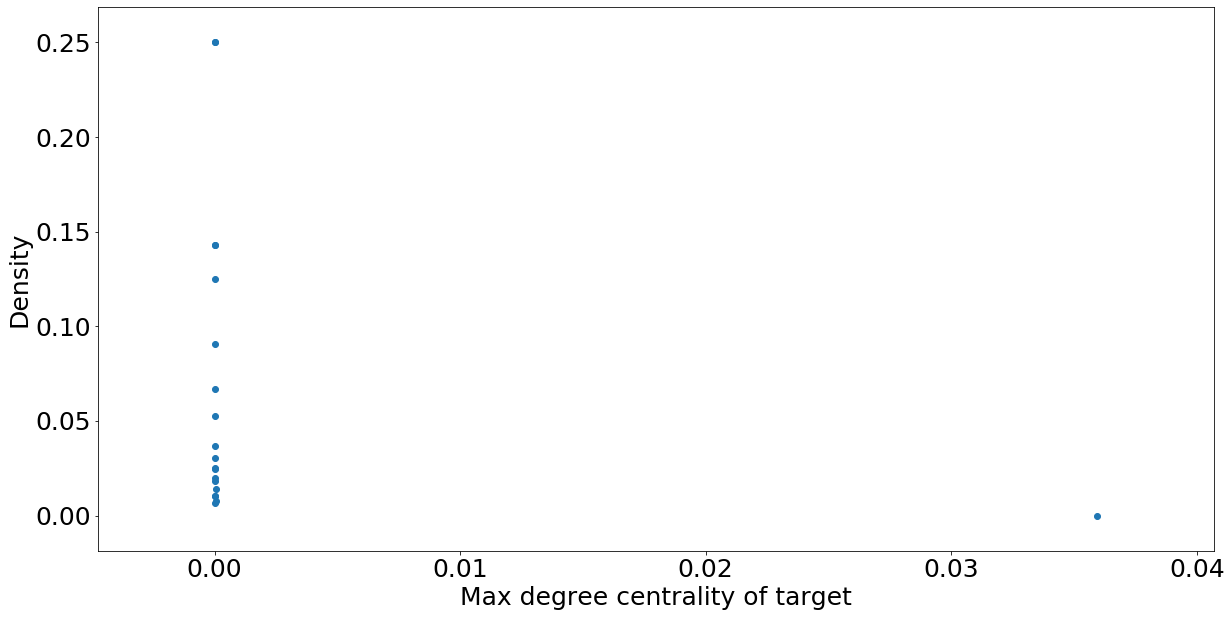

In [13]:
fig = plt.figure(figsize=(20,10))
x = dfScam['MaxDC'].values
y = dfScam['Density'].values
plt.xlabel("Max degree centrality of target")
plt.ylabel("Density")
plt.scatter(x, y)
plt.show()

In [21]:
from plotly.offline import init_notebook_mode, iplot
from bubbly.bubbly import bubbleplot
# from __future__ import division
# init_notebook_mode()
import plotly as py
py.offline.init_notebook_mode(connected=True)

In [69]:
dfTemp = pd.DataFrame({"size":[4,4,4,4,4,5,7,8], "gdp":[200,300,1000,500,500,300,200,100],
                       "life":[20,30,10,50,20,20,40,60], "country":["M","M","M","E","M","E","M","E"],
                       "continent":["Asia", "Europe", "Asia", "Europe","Asia", "Europe","Asia", "Europe"],
                       "year":[2000,2000,2001,2001,2002,2002, 2003, 2003]
                      })
dfTemp

,size,gdp,life,country,continent,year
0,4,200,20,M,Asia,2000
1,4,300,30,M,Europe,2000
2,4,1000,10,M,Asia,2001
3,4,500,50,E,Europe,2001
4,4,500,20,M,Asia,2002
5,5,300,20,E,Europe,2002
6,7,200,40,M,Asia,2003
7,8,100,60,E,Europe,2003


In [97]:
figure = bubbleplot(dataset = dfTemp, x_column = 'gdp', y_column = 'life',
                    bubble_column = 'continent', time_column = 'year',  
#                     size_column = 'life', 
#                     color_column='continent',
                    x_title="GDP per Capita", y_title="Life Expectancy", title='Gapminder Global Indicators',
                    x_logscale=True, scale_bubble=3, height=650)
iplot(figure)
#save as html
# py.offline.plot(figure, filename='myplot.html')

In [17]:
filename = "D:/Users/figohjs/Documents/Network/data/interim/2021-03-19_ScamAccountSummary.csv"
dfAccount = pd.read_csv(filename)

#there is one record with wrong year
dfAccount = dfAccount.query("Year != 'p1207'")

#clean year column
dfAccount['Year'] = dfAccount['Year'].map(lambda x:int(x[1:]))

In [18]:
dfAccountGrouped = dfAccount.groupby(["State", "RI", "Year"])\
                    .agg({"Amount":[np.sum, "count"]}).reset_index()

dfAccountGrouped.columns = [i[1] if i[1]!='' else i[0] for i in dfAccountGrouped.columns]

In [19]:
dfAccountGrouped

,State,RI,Year,sum,count
0,JOHOR,Affin Bank Berhad,2012,1.054582e+07,8
1,JOHOR,Affin Bank Berhad,2013,1.037966e+09,212
2,JOHOR,Affin Bank Berhad,2014,3.743640e+08,469
3,JOHOR,Affin Bank Berhad,2015,1.115825e+08,439
4,JOHOR,Affin Bank Berhad,2016,2.023431e+08,244
...,...,...,...,...,...
4772,W.P PUTRAJAYA,RHB Bank Berhad,2018,4.798738e+08,29
4773,W.P PUTRAJAYA,RHB Bank Berhad,2019,3.490268e+08,19
4774,W.P PUTRAJAYA,RHB Bank Berhad,2020,2.732171e+08,5
4775,W.P PUTRAJAYA,RHB Bank Berhad,2021,1.459526e+07,1


In [39]:
#choose top 10 states
top10 = dfAccount.groupby(["State"])['Amount'].sum().reset_index()\
.sort_values('Amount', ascending = False)['State'][:10].values

In [49]:
top10Dict = {i:no for no,i in enumerate(top10)}

In [40]:
dfTemp = dfAccountGrouped.query('State in @top10')\
        .sort_values("Year")

In [50]:
dfTemp['StateNo'] = dfTemp['State'].map(top10Dict)

In [57]:
figure = bubbleplot(dataset = dfTemp, x_column = 'count', y_column = 'sum',
                    bubble_column = 'RI', time_column = 'Year',  
                    size_column = 'sum', 
                    color_column = 'StateNo',
                    colorscale = px.colors.qualitative.Antique,
                    z_column = "State",
                    x_title = "Number of account", y_title = "CTR Amount", title = 'CTR amount vs number by year (top 10 States)',
                    x_logscale = True, scale_bubble = 3, height = 650)
iplot(figure)
#save as html
# py.offline.plot(figure, filename='top10States.html')

TypeError: can't multiply sequence by non-int of type 'float'

In [26]:
import plotly.express as px

print(px.colors.qualitative.Set3)

['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)', 'rgb(255,237,111)']


In [30]:
px.colors.qualitative.Antique

['rgb(133, 92, 117)',
 'rgb(217, 175, 107)',
 'rgb(175, 100, 88)',
 'rgb(115, 111, 76)',
 'rgb(82, 106, 131)',
 'rgb(98, 83, 119)',
 'rgb(104, 133, 92)',
 'rgb(156, 156, 94)',
 'rgb(160, 97, 119)',
 'rgb(140, 120, 93)',
 'rgb(124, 124, 124)']